In [186]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve

from textblob import TextBlob

import nltk
from nltk.stem.wordnet import WordNetLemmatizer



In [110]:
df = pd.read_csv("emphasizedwords.csv")
df.head()

,#,emphasized,actual,sentiment
0,1,liiiike,like,1
1,2,loveeee,love,1
2,3,loooove,love,1
3,4,baaaddd,bad,0
4,5,noooooooo,no,0


In [111]:
def tokens(review):
    return TextBlob(review).words

df.head().emphasized.apply(tokens)

0      [liiiike]
1      [loveeee]
2      [loooove]
3      [baaaddd]
4    [noooooooo]
Name: emphasized, dtype: object

In [112]:
def to_lemmas(review):
    wordss = TextBlob(review.lower()).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in wordss]

df.emphasized.head().apply(to_lemmas)

0      [liiiike]
1      [loveeee]
2      [loooove]
3      [baaaddd]
4    [noooooooo]
Name: emphasized, dtype: object

In [113]:
bow_transformer = CountVectorizer(analyzer=to_lemmas).fit(df['emphasized'])
print(len(bow_transformer.vocabulary_))

review_bow = bow_transformer.transform(df['emphasized'])
print( 'sparse matrix shape:', review_bow.shape)
print('number of non-zeros:', review_bow.nnz) #learn this
print( 'sparsity: %.2f%%' % (100.0 * review_bow.nnz))

18
sparse matrix shape: (18, 18)
number of non-zeros: 18
sparsity: 1800.00%


In [137]:
tfidf_transformer =TfidfTransformer().fit(review_bow)
review_tfidf = tfidf_transformer.transform(review_bow)
review_tfidf.shape

text_train, text_test, liked_train, liked_test = train_test_split(df['emphasized'], df['sentiment'], test_size=0.50)

In [129]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=to_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),
])

param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

In [130]:
grid_svm = GridSearchCV(
    pipeline_svm, #object used to fit the data
    param_grid=param_svm, 
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores" i.e. to run on all CPUs
    scoring='accuracy',#optimizing parameter
#     cv=StratifiedKFold(liked_train, n_splits=15),
    cv= StratifiedKFold(n_splits=2, shuffle=False, random_state=None),
)

In [131]:
%time classifier = grid_svm.fit(text_train, liked_train) # find the best combination from param_svm

Wall time: 55.1 ms


In [132]:
print(classifier.score)

<bound method BaseSearchCV.score of GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('bow',
                                        CountVectorizer(analyzer=<function to_lemmas at 0x00000266E0B8E1F0>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('classifier', SVC())]),
             n_jobs=-1,
             param_grid=[{'classifier__C': [1, 10, 100, 1000],
                          'classifier__kernel': ['linear']},
                         {'classifier__C': [1, 10, 100, 1000],
                          'classifier__gamma': [0.001, 0.0001],
                          'classifier__kernel': ['rbf']}],
             scoring='accuracy')>


In [159]:
print(classification_report(liked_test, classifier.predict(text_test)))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.75      1.00      0.86         6

    accuracy                           0.78         9
   macro avg       0.88      0.67      0.68         9
weighted avg       0.83      0.78      0.74         9



[[1 3]
 [2 3]]


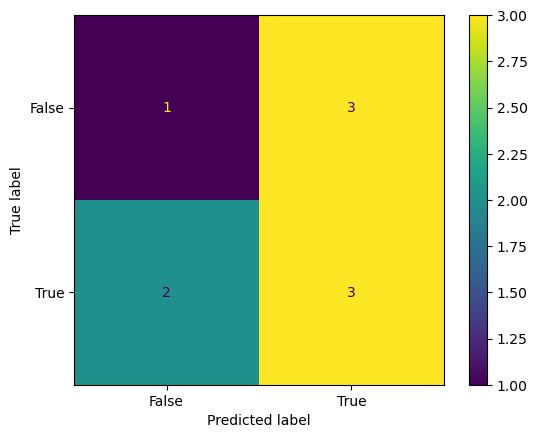

In [190]:
# confusion_matrix = confusion_matrix(text_train.tolist(), text_test.tolist())
# from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(liked_train.tolist(), liked_test.tolist())
print(cfm)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = [False, True])

cm_display.plot()
plt.show()
# text_train.tolist()
# text_test.tolist()

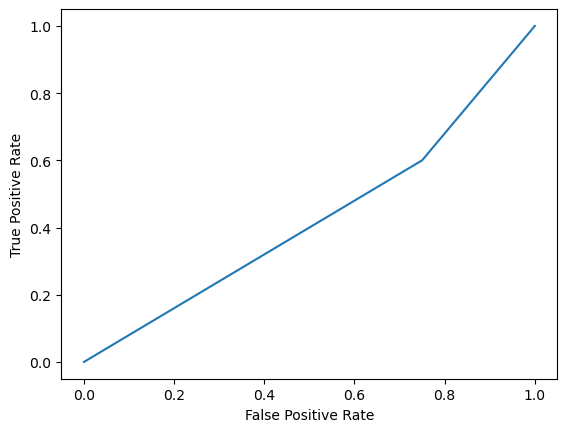

In [191]:
def plot_roc_curve(true_y, y_prob):
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(liked_train.tolist(), liked_test.tolist())

# print(f'model 1 AUC score: {roc_auc_score(liked_train.tolist(), liked_test.tolist())}')

In [97]:
def gaussKernel(x1, x2, sigma):
    ss=np.power(sigma,2)
    norm= (x1-x2).T.dot(x1-x2)
    return np.exp(-norm/(2*ss))
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2
gaussKernel(x1,x2,sigma)

NameError: name 'np' is not defined

In [32]:
# X = df.drop(['#'], axis=1)
X = df["emphasized"]
y = df["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1, test_size= 0.2)

In [29]:
vect = CountVectorizer(stop_words='english', ngram_range = (1,1), max_df = .80, min_df = 0)
vect.fit(X_train)

ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [24]:
# nb = MultinomialNB()
# nb.fit(X_train, y_train)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
# y_pred = knn.predict(X_test)

ValueError: could not convert string to float: 'baaaad'